# Experiment of Feed Forward Network in predicting the price movements of SP500

In [21]:
import pickle
import pandas as pd
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
# import quandl
import nltk
import itertools
import torch
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
import collections
from sklearn.manifold import Isomap,MDS
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import sklearn
import statsmodels
yf.pdr_override()
import scipy.stats as scs
import statsmodels.api as sm
import seaborn as sns
from sklearn.metrics import classification,confusion_matrix,matthews_corrcoef,accuracy_score,classification_report
from models.ffn_classifier import FFNClassifier
import scipy.stats as stats
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Price Data Preparation

In [2]:
def reset_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

In [3]:
lmap=lambda fun,it:list(map(lambda x:fun(x),it))

In [4]:
securities = pdr.get_data_yahoo(["SPY"], start="2005-01-01", end="2018-05-30")

[*********************100%***********************]  1 of 1 downloaded


In [5]:
class_number=2

In [6]:
data=securities['Adj Close'].fillna(method='ffill')
diff=(data.shift(-1)/data-1).fillna(0)
real_diff=data.shift(-1)-data.fillna(0)
labels=pd.qcut(diff,q=class_number,labels=range(class_number)).astype(int)

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


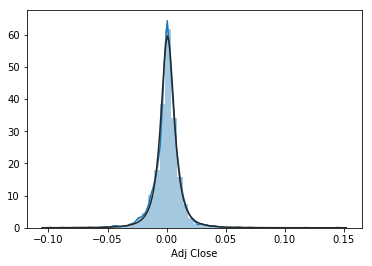

In [7]:
sns.distplot(diff,fit=stats.t)

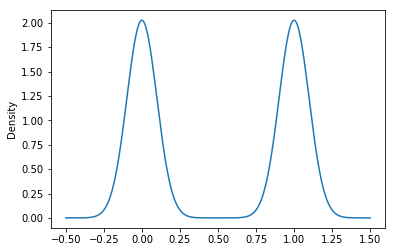

In [8]:
labels.plot(kind='kde')

## Define Test Function

In [19]:
def test(x,y,model,test_size=15,train_size=128,epoch=100, log_interval=10):
    train_loss=[]
    train_acc=[]
    train_mcc=[]
    dev_loss=[]
    dev_acc=[]
    dev_mcc=[]
    best_result=None
    best_score=0
    global_step=0
    best_result_epoch=0
    for e in tqdm_notebook(range(epoch)):
        pointer=0
        
        chunk_train_loss=0
        chunk_train_acc=0
        chunk_train_mcc=0
        train_count=0
        
        chunk_test_loss=0
        chunk_test_acc=0
        chunk_test_mcc=0
        test_count=0
        test_yhat=[]
        y_true=[]
        
        while pointer<len(x):
            
            train_x=x[pointer:pointer+train_size]
            train_y=y[pointer:pointer+train_size]
            train_length=len(train_x)
            b_pointer=0
            while b_pointer<train_length:
                random_batch_size=np.random.randint(low=32,high=128)
                batch_x=train_x[b_pointer:b_pointer+random_batch_size]
                batch_y=train_y[b_pointer:b_pointer+random_batch_size]
                loss,acc,mcc,_=model.train(X=batch_x,y=batch_y)
                chunk_train_loss+=loss
                chunk_train_acc+=acc
                chunk_train_mcc+=mcc
                b_pointer+=len(batch_x)
                pointer+=len(batch_x)
                global_step+=1
                train_count+=1
            if pointer>=len(x):
                break
            test_x=x[pointer:pointer+test_size]
            test_y=y[pointer:pointer+test_size]
            loss,acc,mcc,y_hat=model.test(X=test_x,y=test_y)
            test_yhat.append(y_hat)
            y_true.append(test_y)
            chunk_test_loss+=loss
            chunk_test_acc+=acc
            chunk_test_mcc+=mcc
            test_count+=1
            pointer+=len(test_x)
        chunk_train_loss=chunk_train_loss/train_count
        chunk_train_acc=chunk_train_acc/train_count
        chunk_train_mcc=chunk_train_mcc/train_count
        
        train_loss.append(chunk_train_loss)
        train_acc.append(chunk_train_acc)
        train_mcc.append(chunk_train_mcc)
        
        test_yhat=np.concatenate(test_yhat)
        y_true=np.concatenate(y_true)
        chunk_test_loss=chunk_test_loss/test_count
        chunk_test_acc=accuracy_score(y_pred=test_yhat,y_true=y_true)
        chunk_test_mcc=matthews_corrcoef(y_pred=test_yhat,y_true=y_true)
        
        if chunk_test_mcc+chunk_test_acc>best_score:
            best_result=test_yhat.copy()
            best_score=chunk_test_mcc+chunk_test_acc
            best_result_epoch=e
        
        
        dev_loss.append(chunk_test_loss)
        dev_acc.append(chunk_test_acc)
        dev_mcc.append(chunk_test_mcc)
        if e%log_interval==0:
            print('test loss',dev_loss[-1],'test acc',dev_acc[-1],'test mcc',dev_mcc[-1],'epoch:',e)
            print('best_result_epoch',best_result_epoch,'acc',dev_acc[best_result_epoch],'mcc',dev_mcc[best_result_epoch])
    return np.array(train_loss),np.array(train_acc),np.array(train_mcc),np.array(dev_loss),np.array(dev_acc), np.array(dev_mcc), best_result,y_true.flatten()

In [10]:
def trade(a,price_diff,initial_price,test_size=15,train_size=128):
    pointer=0
    test_r=initial_price
    bnh_r=initial_price
    while pointer<len(x):
        pointer+=train_size
        if pointer>=len(x):
            break
        test_a=a[pointer:pointer+test_size]
        test_a=test_a*2-1
        test_p=price_diff[pointer:pointer+test_size]
        test_r+=(test_p*test_a).sum()
        bnh_r+=test_p.sum()
        pointer+=len(test_p)
    return test_r,bnh_r,test_r/initial_price,bnh_r/initial_price

In [24]:
# -*- coding:utf-8 -*-

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score, matthews_corrcoef
import os


class FFN(nn.Module):
    def __init__(self, d_x, d_h, d_o, ffn_layers=5, dp=0.5):
        super(FFN, self).__init__()
        self.f_in = nn.Linear(in_features=d_x, out_features=d_h)
        self.hiddens = nn.ModuleList([nn.Linear(in_features=d_h, out_features=d_h) for _ in range(ffn_layers)])
        self.lms = nn.ModuleList([nn.LayerNorm(d_h) for _ in range(ffn_layers)])
        self.f_out = nn.Linear(in_features=d_h, out_features=d_o)
        self.dropout = nn.Dropout(p=dp)
    
    def forward(self, x):
        x_in = self.dropout(self.f_in(x))
        output = x_in
        for hl, lm in zip(self.hiddens, self.lms):
            output = self.dropout(lm(F.leaky_relu(hl(output))))
        output = self.f_out(x_in + output)
        return output


class FFNClassifier(object):
    def __init__(self, d_x, d_h, d_o, lr=1e-3, dp=0.5, ffn_layers=5):
        super(FFNClassifier, self).__init__()
        self.ffn = FFN(d_x, d_h, d_o=d_o, dp=dp, ffn_layers=ffn_layers)
        self.loss_func = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.ffn.parameters(), lr=lr)
        for p in self.ffn.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    
    def train(self, X, y):
        x = torch.tensor(X, dtype=torch.float32)
        y_true = torch.tensor(y, dtype=torch.long)
        self.optimizer.zero_grad()
        y_hat = self.ffn(x)
        loss = self.loss_func(y_hat, y_true).mean()
        loss.backward()
        clip_grad_norm_(self.ffn.parameters(), 1)
        self.optimizer.step()
        topv, topi = y_hat.topk(1)
        y_hat = topi.view(-1).detach()
        acc = accuracy_score(y_true=y.flatten(), y_pred=y_hat)
        mcc = matthews_corrcoef(y_true=y.flatten(), y_pred=y_hat)
        return loss.item(), acc, mcc, y_hat
    
    def test(self, X, y):
        with torch.no_grad():
            x = torch.tensor(X, dtype=torch.float32)
            y_true = torch.tensor(y, dtype=torch.long)
            y_hat = self.ffn(x)
            loss = self.loss_func(y_hat, y_true).mean()
            topv, topi = y_hat.topk(1)
            y_hat = topi.view(-1).detach()
            acc = accuracy_score(y_true=y.flatten(), y_pred=y_hat)
            mcc = matthews_corrcoef(y_true=y.flatten(), y_pred=y_hat)
            return loss.item(), acc, mcc, y_hat
    
    def inference(self, X):
        with torch.no_grad():
            x = torch.tensor(X, dtype=torch.float32)
            y_hat = self.ffn(x)
            topv, topi = y_hat.topk(1)
            y_hat = topi.view(-1).detach()
            return y_hat

    def load_model(self, model_path='./FFNModel'):
        self.ffn = torch.load(model_path + '/model.pkl')

    def save_model(self, model_path='./FFNModel'):
        if not os.path.exists(model_path):
            os.mkdir(model_path)
        torch.save(self.ffn, model_path + '/model.pkl')

### Experiment of pre-trained elmo encoded title, (mean with date)

In [101]:
reset_seed(1)

Each news title is a vector produced by mean of Elmo representation

In [102]:
date_index=np.load('data/title_elmo_index.npy')
content=np.load('data/title_elmo.npy')
content=pd.DataFrame(content,index=date_index)
content=content.groupby(content.index).mean()
content=content.join(labels).fillna(method='bfill').dropna()['2010-06':]

In [103]:
x=content.iloc[:,:-1].values
y=content.iloc[:,-1].values

In [104]:
clf=FFNClassifier(d_x=x.shape[-1],d_h=300,d_o=class_number,dp=0.5,ffn_layers=5,lr=1e-3)

In [105]:
train_loss,train_acc,train_mcc,dev_loss,dev_acc,dev_mcc,best_result,test_y=test(model=clf,x=x,y=y,test_size=15,train_size=150,epoch=100,log_interval=5)

test loss 1.4833031577222489 test acc 0.5568627450980392 test mcc 0.10582528548093734 epoch: 0
best_result_epoch 0 acc 0.5568627450980392 mcc 0.10582528548093734
test loss 0.8476952980546391 test acc 0.4470588235294118 test mcc -0.11023963796102461 epoch: 5
best_result_epoch 3 acc 0.5607843137254902 mcc 0.11547245703581584
test loss 0.7233493748833152 test acc 0.5254901960784314 test mcc 0.037280056753966284 epoch: 10
best_result_epoch 3 acc 0.5607843137254902 mcc 0.11547245703581584
test loss 0.7132498060955721 test acc 0.5411764705882353 test mcc 0.07959524405032008 epoch: 15
best_result_epoch 3 acc 0.5607843137254902 mcc 0.11547245703581584
test loss 0.7651124666718876 test acc 0.4666666666666667 test mcc -0.06842565779652897 epoch: 20
best_result_epoch 3 acc 0.5607843137254902 mcc 0.11547245703581584
test loss 0.7185778687981998 test acc 0.5372549019607843 test mcc 0.06878654392272061 epoch: 25
best_result_epoch 3 acc 0.5607843137254902 mcc 0.11547245703581584
test loss 0.766871883

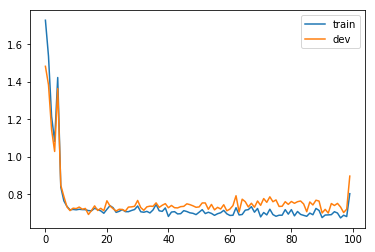

In [106]:
plt.plot(train_loss)
plt.plot(dev_loss)
plt.legend(('train','dev'))

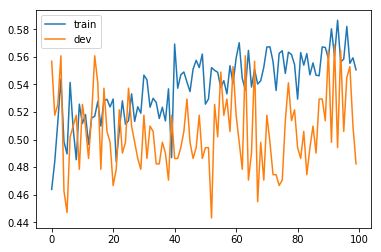

In [107]:
plt.plot(train_acc)
plt.plot(dev_acc)
plt.legend(('train','dev'))

In [108]:
elmo_cr=classification_report(y_pred=best_result,y_true=test_y)
elmo_c=confusion_matrix(y_pred=best_result,y_true=test_y)
elmo_acc=accuracy_score(y_pred=best_result,y_true=test_y)
elmo_mcc=matthews_corrcoef(y_pred=best_result,y_true=test_y)


In [109]:
elmo_acc

0.5686274509803921

In [110]:
elmo_mcc

0.1327190897739648

In [111]:
elmo_c

array([[82, 53],
       [57, 63]])

In [112]:
print(elmo_cr)

              precision    recall  f1-score   support

         0.0       0.59      0.61      0.60       135
         1.0       0.54      0.53      0.53       120

   micro avg       0.57      0.57      0.57       255
   macro avg       0.57      0.57      0.57       255
weighted avg       0.57      0.57      0.57       255



### Experiment of d2v encoded title, (mean with date)

In [48]:
reset_seed(1)

In [49]:
date_index=np.load('data/title_d2v_index.npy')
content=np.load('data/title_d2v.npy')
content=pd.DataFrame(content,index=date_index)
content=content.groupby(content.index).mean()
content=content.join(labels).fillna(method='bfill').dropna()['2010-06':]

In [50]:
x=content.iloc[:,:-1].values
y=content.iloc[:,-1].values

In [51]:
clf=FFNClassifier(d_x=x.shape[-1],d_h=300,d_o=class_number,dp=0.5,ffn_layers=5,lr=1e-3)

In [52]:
train_loss,train_acc,train_mcc,dev_loss,dev_acc,dev_mcc,best_result,test_y=test(model=clf,x=x,y=y,test_size=15,train_size=150,epoch=100,log_interval=5)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


test loss 1.0069855837260975 test acc 0.5294117647058824 test mcc 0.05132348017095331 epoch: 0
best_result_epoch 0 acc 0.5294117647058824 mcc 0.05132348017095331
test loss 0.706776384045096 test acc 0.4980392156862745 test mcc -0.014066269825907873 epoch: 5
best_result_epoch 3 acc 0.5568627450980392 mcc 0.10866925145219379
test loss 0.6991961072472965 test acc 0.48627450980392156 test mcc -0.0374602780463495 epoch: 10
best_result_epoch 9 acc 0.5764705882352941 mcc 0.14713425977144276
test loss 0.6937612645766315 test acc 0.5411764705882353 test mcc 0.07044514394801407 epoch: 15
best_result_epoch 9 acc 0.5764705882352941 mcc 0.14713425977144276
test loss 0.6909444507430581 test acc 0.5333333333333333 test mcc 0.0542618000680649 epoch: 20
best_result_epoch 9 acc 0.5764705882352941 mcc 0.14713425977144276
test loss 0.6846869833329144 test acc 0.5411764705882353 test mcc 0.09032926074575916 epoch: 25
best_result_epoch 9 acc 0.5764705882352941 mcc 0.14713425977144276
test loss 0.69532256266

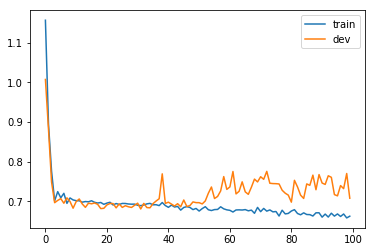

In [53]:
plt.plot(train_loss)
plt.plot(dev_loss)
plt.legend(('train','dev'))

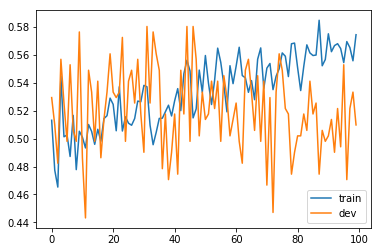

In [54]:
plt.plot(train_acc)
plt.plot(dev_acc)
plt.legend(('train','dev'))

In [55]:
d2vc_cr=classification_report(y_pred=best_result,y_true=test_y)
d2vc_c=confusion_matrix(y_pred=best_result,y_true=test_y)
d2vc_acc=accuracy_score(y_pred=best_result,y_true=test_y)
d2vc_mcc=matthews_corrcoef(y_pred=best_result,y_true=test_y)


In [56]:
d2vc_acc

0.5803921568627451

In [57]:
d2vc_mcc

0.15826496200703177

In [58]:
d2vc_c

array([[81, 54],
       [53, 67]])

In [59]:
print(d2vc_cr)

              precision    recall  f1-score   support

         0.0       0.60      0.60      0.60       135
         1.0       0.55      0.56      0.56       120

   micro avg       0.58      0.58      0.58       255
   macro avg       0.58      0.58      0.58       255
weighted avg       0.58      0.58      0.58       255



### Experiment of d2v encoded content, (mean with date)

In [60]:
reset_seed(1)

In [61]:
date_index=np.load('data/content_d2v_index.npy')
content=np.load('data/content_d2v.npy')
content=pd.DataFrame(content,index=date_index)
content=content.groupby(content.index).mean()
content=content.join(labels).fillna(method='bfill').dropna()['2010-06':]

In [62]:
x=content.iloc[:,:-1].values
y=content.iloc[:,-1].values

In [63]:
clf=FFNClassifier(d_x=x.shape[-1],d_h=300,d_o=class_number,dp=0.5,ffn_layers=5,lr=1e-3)

In [64]:
train_loss,train_acc,train_mcc,dev_loss,dev_acc,dev_mcc,best_result,test_y=test(model=clf,x=x,y=y,test_size=15,train_size=150,epoch=100,log_interval=5)

test loss 1.1779037871781517 test acc 0.5058823529411764 test mcc 0.009251837921381402 epoch: 0
best_result_epoch 0 acc 0.5058823529411764 mcc 0.009251837921381402
test loss 0.7360386848449707 test acc 0.5411764705882353 test mcc 0.07324670207647144 epoch: 5
best_result_epoch 5 acc 0.5411764705882353 mcc 0.07324670207647144
test loss 0.7041222558302038 test acc 0.5254901960784314 test mcc 0.038078456188115714 epoch: 10
best_result_epoch 5 acc 0.5411764705882353 mcc 0.07324670207647144
test loss 0.7286390416762408 test acc 0.5019607843137255 test mcc -0.008504625884633158 epoch: 15
best_result_epoch 5 acc 0.5411764705882353 mcc 0.07324670207647144
test loss 0.7230807016877567 test acc 0.5294117647058824 test mcc 0.062010248271760986 epoch: 20
best_result_epoch 5 acc 0.5411764705882353 mcc 0.07324670207647144
test loss 0.6939297774258781 test acc 0.5254901960784314 test mcc 0.04465721088311389 epoch: 25
best_result_epoch 22 acc 0.5411764705882353 mcc 0.07628940192531956
test loss 0.72904

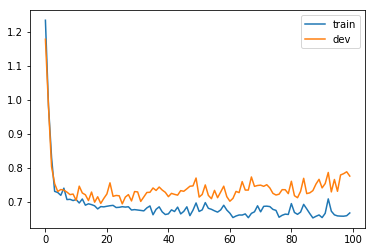

In [65]:
plt.plot(train_loss)
plt.plot(dev_loss)
plt.legend(('train','dev'))

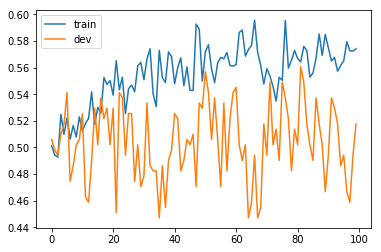

In [66]:
plt.plot(train_acc)
plt.plot(dev_acc)
plt.legend(('train','dev'))

In [67]:
d2vt_cr=classification_report(y_pred=best_result,y_true=test_y)
d2vt_c=confusion_matrix(y_pred=best_result,y_true=test_y)
d2vt_acc=accuracy_score(y_pred=best_result,y_true=test_y)
d2vt_mcc=matthews_corrcoef(y_pred=best_result,y_true=test_y)


In [68]:
print(d2vt_cr)

              precision    recall  f1-score   support

         0.0       0.59      0.55      0.57       135
         1.0       0.53      0.57      0.55       120

   micro avg       0.56      0.56      0.56       255
   macro avg       0.56      0.56      0.56       255
weighted avg       0.56      0.56      0.56       255



In [69]:
d2vt_c

array([[74, 61],
       [51, 69]])

In [70]:
d2vt_acc

0.5607843137254902

In [71]:
d2vt_mcc

0.12295854349659245

### Experiment of RNN auto-encoder encoded title, (mean with date)

In [72]:
reset_seed(1)

In [73]:
date_index=np.load('data/title_ae_index.npy')
content=np.load('data/title_ae.npy')
content=pd.DataFrame(content,index=date_index)
content=content.groupby(content.index).mean()
content=content.join(labels).fillna(method='bfill').dropna()['2010-06':]

In [74]:
x=content.iloc[:,:-1].values
y=content.iloc[:,-1].values

In [76]:
clf=FFNClassifier(d_x=x.shape[-1],d_h=300,d_o=class_number,dp=0.5,ffn_layers=5,lr=1e-3)

In [77]:
train_loss,train_acc,train_mcc,dev_loss,dev_acc,dev_mcc,best_result,test_y=test(model=clf,x=x,y=y,test_size=15,train_size=150,epoch=100,log_interval=5)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


test loss 2.4866365650120903 test acc 0.5215686274509804 test mcc 0.03805232643868921 epoch: 0
best_result_epoch 0 acc 0.5215686274509804 mcc 0.03805232643868921
test loss 0.9992581465665031 test acc 0.5294117647058824 test mcc 0.05915710062774092 epoch: 5
best_result_epoch 2 acc 0.5568627450980392 mcc 0.10649983287504712
test loss 0.754669354242437 test acc 0.47843137254901963 test mcc -0.04822859623791284 epoch: 10
best_result_epoch 9 acc 0.5607843137254902 mcc 0.11477796474595013
test loss 0.7132123813909643 test acc 0.5176470588235295 test mcc 0.031497039417435604 epoch: 15
best_result_epoch 14 acc 0.5764705882352941 mcc 0.14849688366317737
test loss 0.7281834693516002 test acc 0.4980392156862745 test mcc -0.017038855027411946 epoch: 20
best_result_epoch 14 acc 0.5764705882352941 mcc 0.14849688366317737
test loss 0.7353194706580218 test acc 0.4823529411764706 test mcc -0.04182965508814092 epoch: 25
best_result_epoch 14 acc 0.5764705882352941 mcc 0.14849688366317737
test loss 0.7631

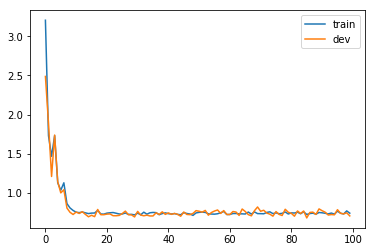

In [78]:
plt.plot(train_loss)
plt.plot(dev_loss)
plt.legend(('train','dev'))

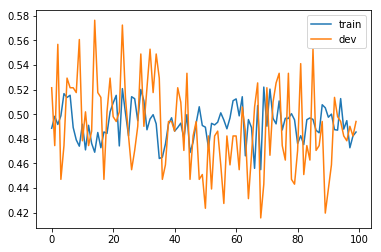

In [79]:
plt.plot(train_acc)
plt.plot(dev_acc)
plt.legend(('train','dev'))

In [80]:
aet_cr=classification_report(y_pred=best_result,y_true=test_y)
aet_c=confusion_matrix(y_pred=best_result,y_true=test_y)
aet_acc=accuracy_score(y_pred=best_result,y_true=test_y)
aet_mcc=matthews_corrcoef(y_pred=best_result,y_true=test_y)


In [81]:
print(aet_cr)

              precision    recall  f1-score   support

         0.0       0.60      0.61      0.61       135
         1.0       0.55      0.53      0.54       120

   micro avg       0.58      0.58      0.58       255
   macro avg       0.57      0.57      0.57       255
weighted avg       0.58      0.58      0.58       255



In [82]:
aet_c

array([[83, 52],
       [56, 64]])

In [83]:
aet_acc

0.5764705882352941

In [84]:
aet_mcc

0.14849688366317737

In [85]:
random_result=[]
for _ in range(50):
    random_y=np.random.randint(low=0,high=2,size=test_y.shape[0])
    random_result.append([accuracy_score(y_pred=random_y,y_true=test_y),matthews_corrcoef(y_pred=random_y,y_true=test_y)])

In [86]:
np.save('results/ci_random',np.array(random_result))

### 2.3 Experiment of pure Glove word embedding titles (mean with each title, mean with date)

In [87]:
reset_seed(1)

In [88]:
date_index=np.load('data/title_glove_index.npy')
content=np.load('data/title_glove.npy')
content=pd.DataFrame(content,index=date_index)
content=content.groupby(content.index).mean()
content=content.join(labels).fillna(method='bfill').dropna()['2010-06':]

In [89]:
x=content.iloc[:,:-1].values
y=content.iloc[:,-1].values

In [90]:
clf=FFNClassifier(d_x=x.shape[-1],d_h=300,d_o=class_number,dp=0.5,ffn_layers=5,lr=1e-3)

In [91]:
train_loss,train_acc,train_mcc,dev_loss,dev_acc,dev_mcc,best_result,test_y=test(model=clf,x=x,y=y,test_size=15,train_size=150,epoch=100,log_interval=5)

test loss 1.0173067310277153 test acc 0.5725490196078431 test mcc 0.14907407407407408 epoch: 0
best_result_epoch 0 acc 0.5725490196078431 mcc 0.14907407407407408
test loss 0.7228673591333277 test acc 0.5215686274509804 test mcc 0.032075014954979206 epoch: 5
best_result_epoch 0 acc 0.5725490196078431 mcc 0.14907407407407408
test loss 0.7047150415532729 test acc 0.49019607843137253 test mcc -0.030008042295270126 epoch: 10
best_result_epoch 0 acc 0.5725490196078431 mcc 0.14907407407407408
test loss 0.7085777591256535 test acc 0.5019607843137255 test mcc -0.011470786693528088 epoch: 15
best_result_epoch 0 acc 0.5725490196078431 mcc 0.14907407407407408
test loss 0.7207674349055571 test acc 0.47843137254901963 test mcc -0.04532004271165183 epoch: 20
best_result_epoch 0 acc 0.5725490196078431 mcc 0.14907407407407408
test loss 0.6957525225246654 test acc 0.5764705882352941 test mcc 0.15164605241392906 epoch: 25
best_result_epoch 25 acc 0.5764705882352941 mcc 0.15164605241392906
test loss 0.720

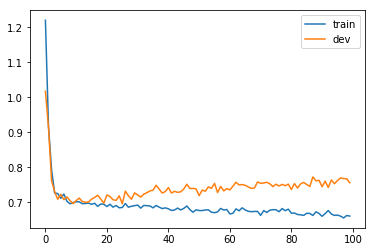

In [94]:
plt.plot(train_loss)
plt.plot(dev_loss)
plt.legend(('train','dev'))

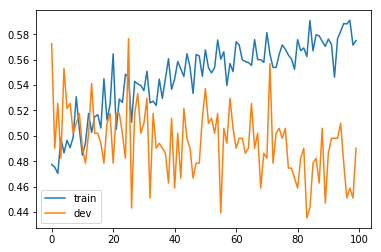

In [95]:
plt.plot(train_acc)
plt.plot(dev_acc)
plt.legend(('train','dev'))

In [96]:
w2vt_cr=classification_report(y_pred=best_result,y_true=test_y)
w2vt_c=confusion_matrix(y_pred=best_result,y_true=test_y)
w2vt_acc=accuracy_score(y_pred=best_result,y_true=test_y)
w2vt_mcc=matthews_corrcoef(y_pred=best_result,y_true=test_y)


In [97]:
print(w2vt_cr)

              precision    recall  f1-score   support

         0.0       0.60      0.59      0.59       135
         1.0       0.55      0.57      0.56       120

   micro avg       0.58      0.58      0.58       255
   macro avg       0.58      0.58      0.58       255
weighted avg       0.58      0.58      0.58       255



In [98]:
w2vt_c

array([[79, 56],
       [52, 68]])

In [99]:
w2vt_acc

0.5764705882352941

In [100]:
w2vt_mcc

0.15164605241392906

In [114]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,use_xlable=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    yticks_axes=plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1.2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    if use_xlable:
        plt.xlabel('Predicted label')
    y_lable_axis=plt.ylabel('True label')

Confusion matrix, without normalization
[[74 61]
 [51 69]]
Confusion matrix, without normalization
[[81 54]
 [53 67]]
Confusion matrix, without normalization
[[83 52]
 [56 64]]
Confusion matrix, without normalization
[[79 56]
 [52 68]]
Confusion matrix, without normalization
[[82 53]
 [57 63]]


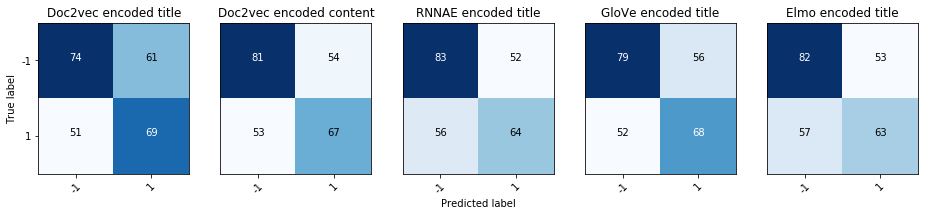

In [116]:
plt.figure(figsize=(13,3))
plt.title('Confusion Matrix for DNN Classifier')
ax1=plt.subplot2grid(shape=(1,5), loc=(0,0), colspan=1)
ax1.set_xlabel('')
plot_confusion_matrix(d2vt_c,classes=[-1,1],title='Doc2vec encoded title')
ax2=plt.subplot2grid((1,5), (0,1), colspan=1)
ax2.set_ylabel('')
ax2.yaxis.set_visible(False)
plot_confusion_matrix(d2vc_c,classes=[-1,1],title='Doc2vec encoded content')
ax3=plt.subplot2grid((1,5), (0,2), colspan=1)
ax3.set_ylabel('')
ax3.yaxis.set_visible(False)
plot_confusion_matrix(aet_c,classes=[-1,1],title='RNNAE encoded title',use_xlable=True)
ax4=plt.subplot2grid((1,5), (0,3), colspan=1)
ax4.set_ylabel('')
ax4.yaxis.set_visible(False)
plot_confusion_matrix(w2vt_c,classes=[-1,1],title='GloVe encoded title')
ax5 = plt.subplot2grid((1,5), (0,4), colspan=1)
ax5.set_ylabel('')
ax5.yaxis.set_visible(False)
plot_confusion_matrix(elmo_c,classes=[-1,1],title='Elmo encoded title')
# plt.colorbar()
plt.tight_layout()
plt.savefig('results/FFN_perf.pdf')